In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [71]:
!ls ../data/a3c

a3c_trajectories_0.csv	a3c_trajectories_1.csv	a3c_trajectories_2.csv


In [72]:
#path = "../results/vanilla_a3c_v2_lite_env_6_UE_100_GPUperEDC_10_consistent_APs_standarize_data_and_Qvalues_rewardFunc_sumPOto3P1to3P2to3_adam_1e3_ep_240_penalty_0/"
path = "../data/"
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",
                "action", "penalty"]
df = pd.read_csv(path+'a3c/a3c_trajectories_0.csv',
                 delimiter=";",
                 names=COLUMN_NAMES,

                )
df

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty
0,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,edc_0,False
1,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,edc_0,False
2,-2.949946,-3.669223,-4.370378,-4.447218,-2.949946,-3.669223,-4.370378,-4.447218,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False
3,-2.725288,-3.619492,-4.308651,-4.459214,-2.949946,-3.669223,-4.370378,-4.447218,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False
4,-2.500629,-3.553835,-4.232293,-4.469914,-2.949946,-3.669223,-4.370378,-4.447218,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,1.543224,1.097128,-0.036492,-4.014751,-2.051312,-1.811359,-2.944980,-4.014751,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,True
2360,1.430895,1.080289,-0.053332,-4.014751,-2.051312,-1.811359,-2.944980,-4.014751,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False
2361,1.318566,1.063450,-0.070171,-4.014751,-2.051312,-1.811359,-2.944980,-4.014751,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False
2362,1.206237,1.046610,-0.087011,-4.014751,-2.051312,-1.811359,-2.944980,-4.014751,-2.949946,-3.669223,-4.370378,-4.447218,edc_0,False


In [73]:
df.action.value_counts()

edc_0    2334
edc_2      26
edc_1       4
Name: action, dtype: int64

In [74]:
df.penalty.value_counts()

False    1855
True      509
Name: penalty, dtype: int64

In [75]:
interval = 100
for i in range(len(df)//interval):
    print(df.iloc[i*interval:(i+1)*interval]["action"].value_counts())

edc_0    100
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    98
edc_2     2
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    98
edc_1     1
edc_2     1
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    100
Name: action, dtype: int64
edc_0    98
edc_2     2
Name: action, dtype: int64
edc_0    95
edc_2     4
edc_1     1
Name: action, dtype: int64
edc_0    99
edc_2     1
Name: action, dtype: int64
edc_0    96
edc_2     3
edc_1     1
Name: action, dtype: int64
edc_0    98
edc_2     2
Name: action, dtype: int64
edc_0    100
Name: ac

In [76]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = COLUMN_NAMES[:-2]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::4]] = scaled_df[scaled_col[0::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::4]] = scaled_df[scaled_col[1::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[2::4]] = scaled_df[scaled_col[2::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[3::4]] = scaled_df[scaled_col[3::4]].apply(inverse_scale_data)

for i in range(3):
    scaled_df["pue_"+str(i)] = scaled_df["power_"+str(i)] / scaled_df["it_"+str(i)]
    
scaled_df["total_pue"] = (scaled_df["pue_0"] + scaled_df["pue_1"] + scaled_df["pue_2"])/3


scaled_df = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

scaled_df.head(5)

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty,pue_0,pue_1,pue_2,total_pue
0,3.516609e-07,250.000000,6.137338e-07,250.000000,3.516609e-07,250.000000,6.137338e-07,250.000000,3.516609e-07,250.000000,6.137338e-07,250.000000,edc_0,False,4.073427e+08,4.073427e+08,4.073427e+08,4.073427e+08
1,3.516609e-07,250.000000,6.137338e-07,250.000000,3.516609e-07,250.000000,6.137338e-07,250.000000,3.516609e-07,250.000000,6.137338e-07,250.000000,edc_0,False,4.073427e+08,4.073427e+08,4.073427e+08,4.073427e+08
2,3.516609e-07,271.261171,1.426765e+02,128.584719,3.516609e-07,271.261171,1.426765e+02,128.584719,3.516609e-07,271.261171,1.426765e+02,128.584719,edc_0,False,1.901233e+00,1.901233e+00,1.901233e+00,1.901233e+00
3,5.000000e+01,280.381301,1.539966e+02,126.384734,3.516609e-07,271.261171,1.426765e+02,128.584719,3.516609e-07,271.261171,1.426765e+02,128.584719,edc_0,False,1.820698e+00,1.901233e+00,1.901233e+00,1.874388e+00
4,1.000000e+02,292.422272,1.679998e+02,124.422455,3.516609e-07,271.261171,1.426765e+02,128.584719,3.516609e-07,271.261171,1.426765e+02,128.584719,edc_0,False,1.740611e+00,1.901233e+00,1.901233e+00,1.847692e+00


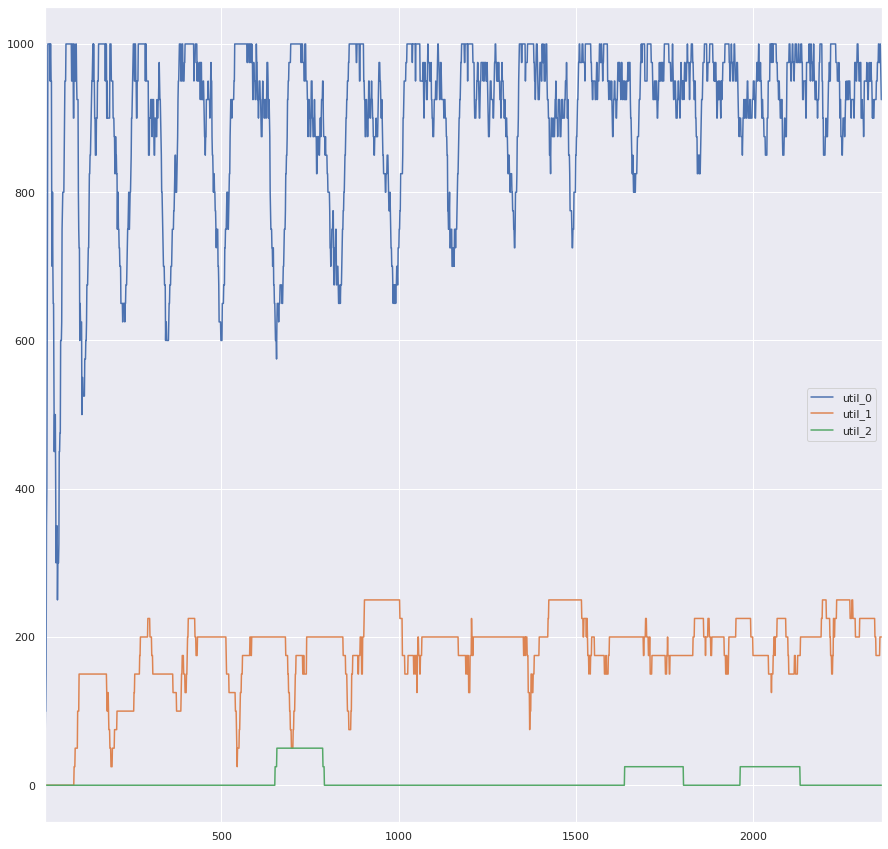

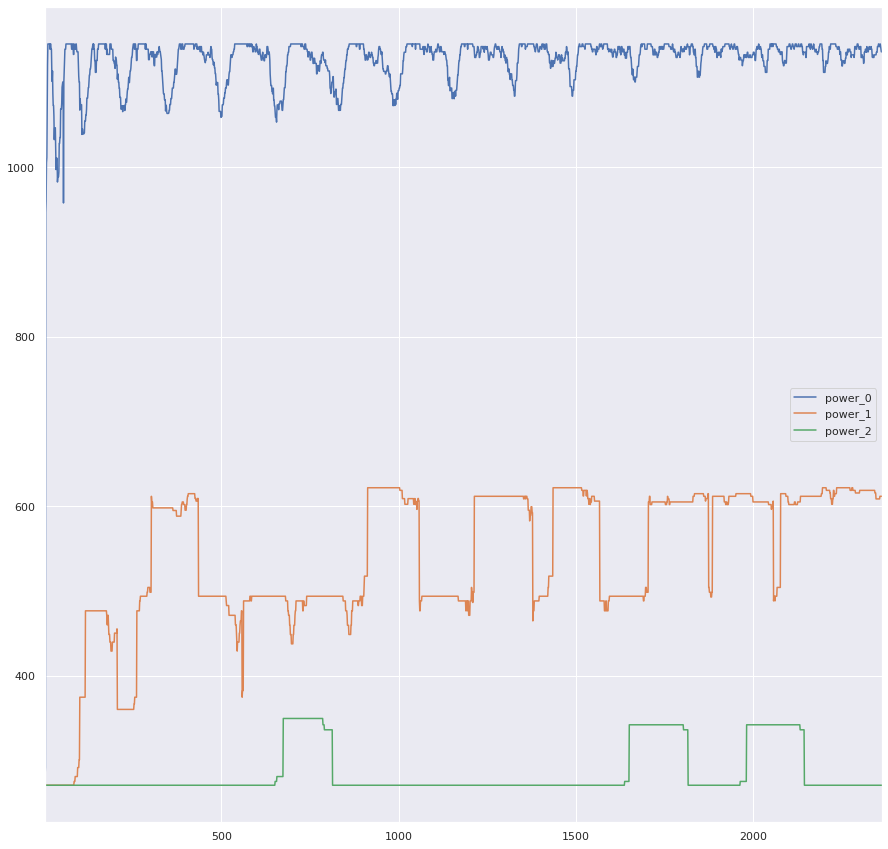

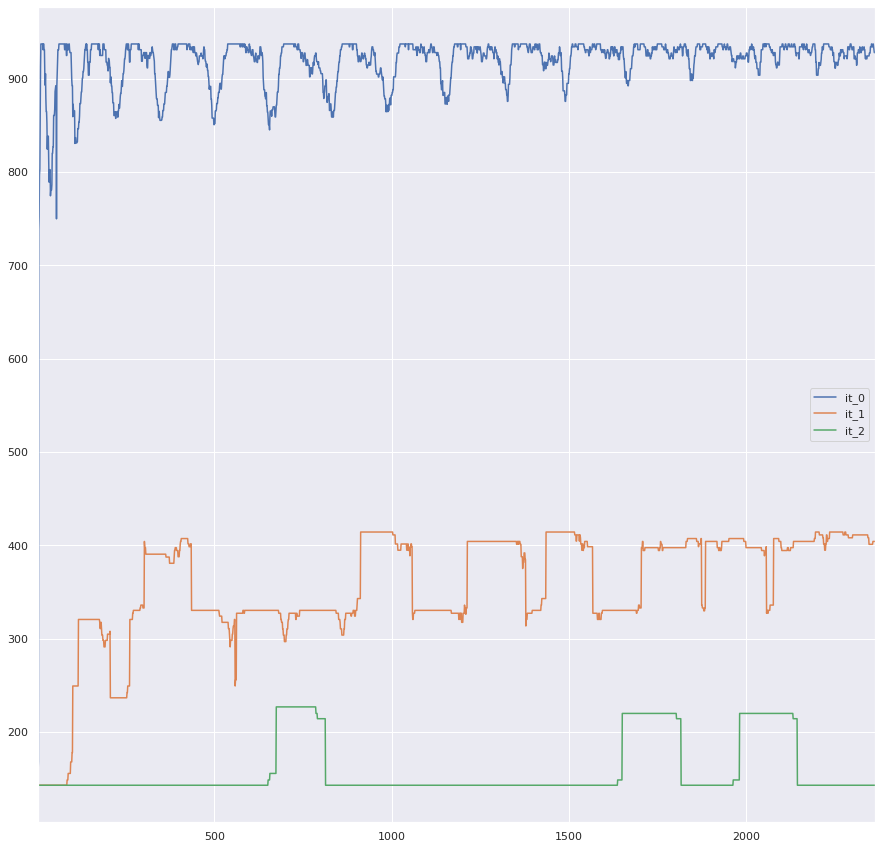

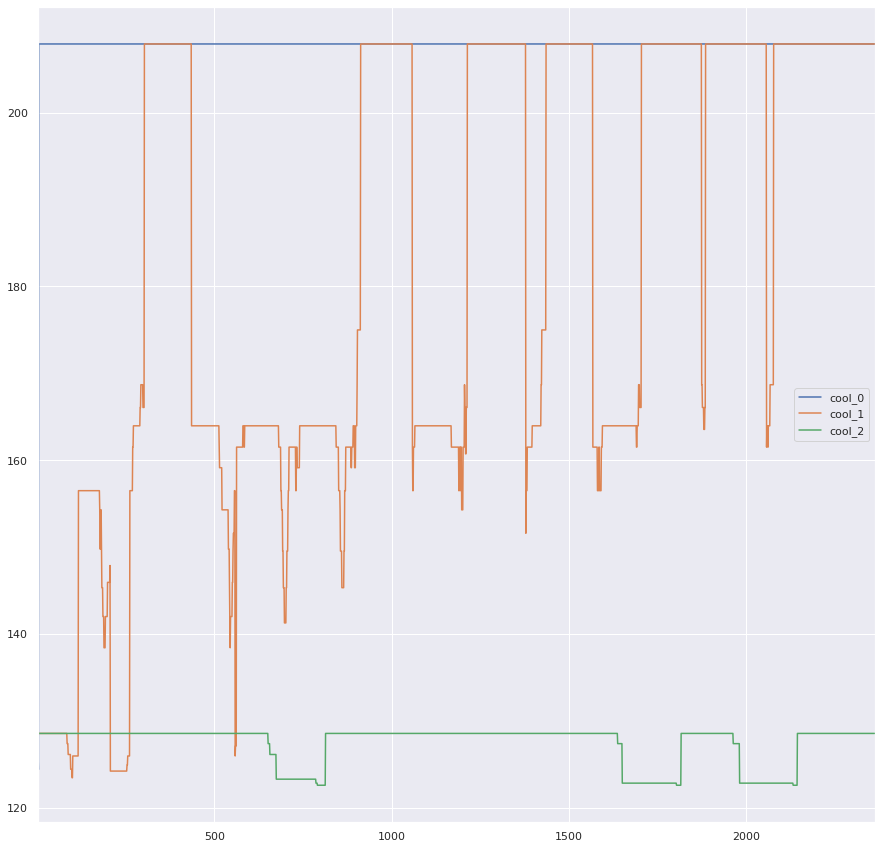

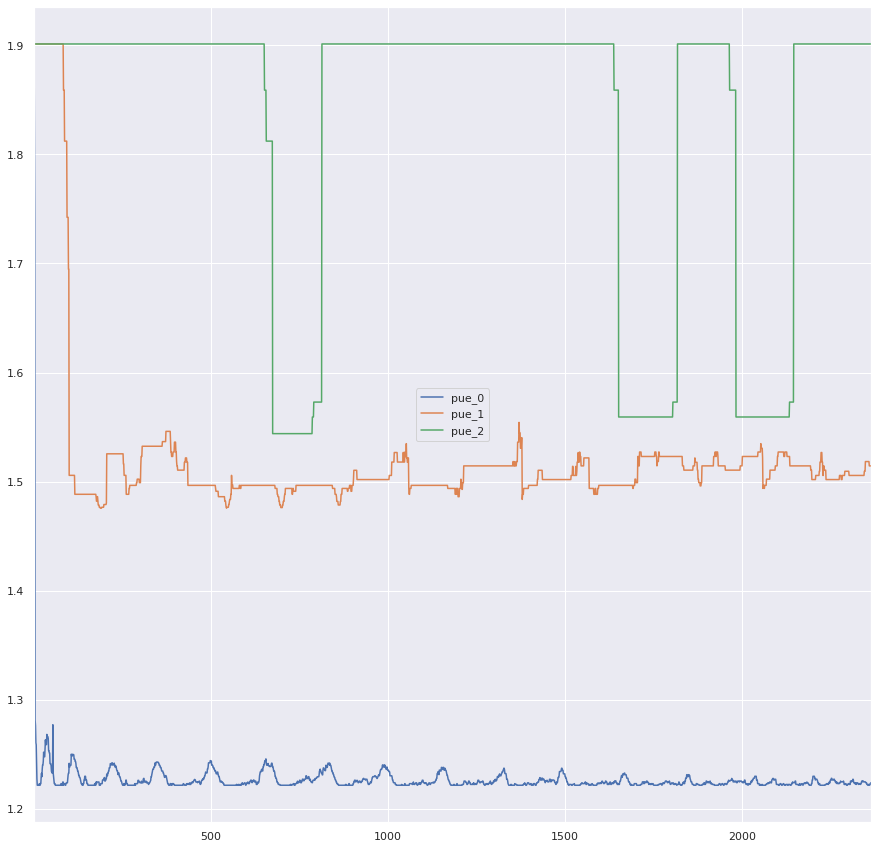

In [77]:
for col in ["util", "power", "it", "cool","pue"]:
    scaled_df.iloc[2:].plot(y=[col+"_0", col+"_1", col+"_2"], figsize=(15,15))

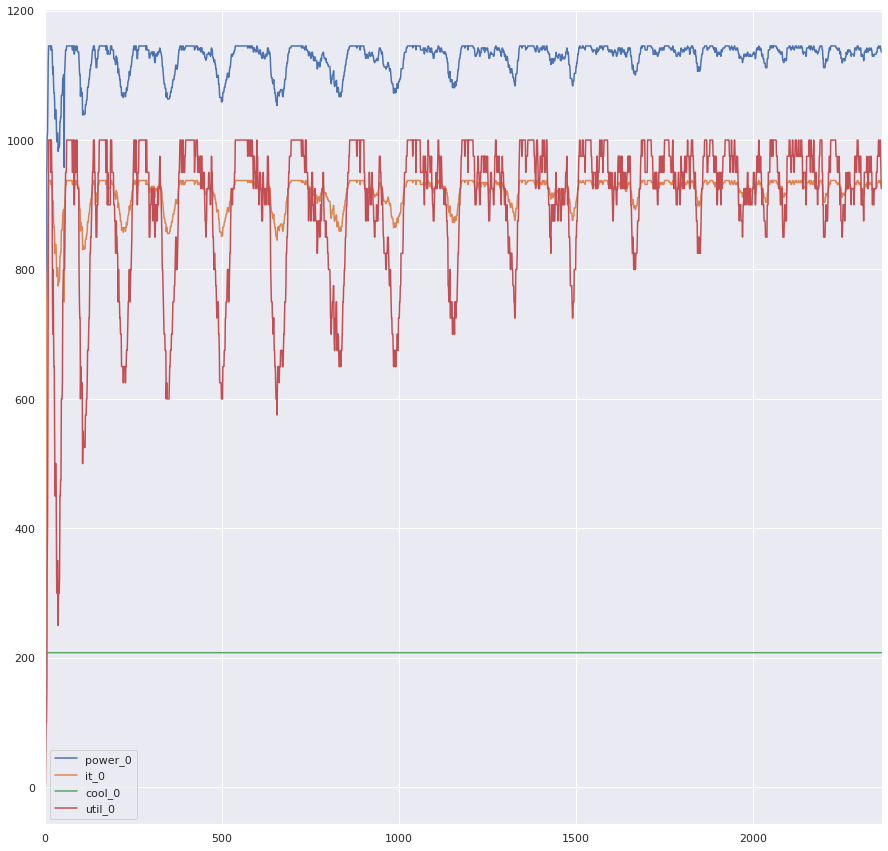

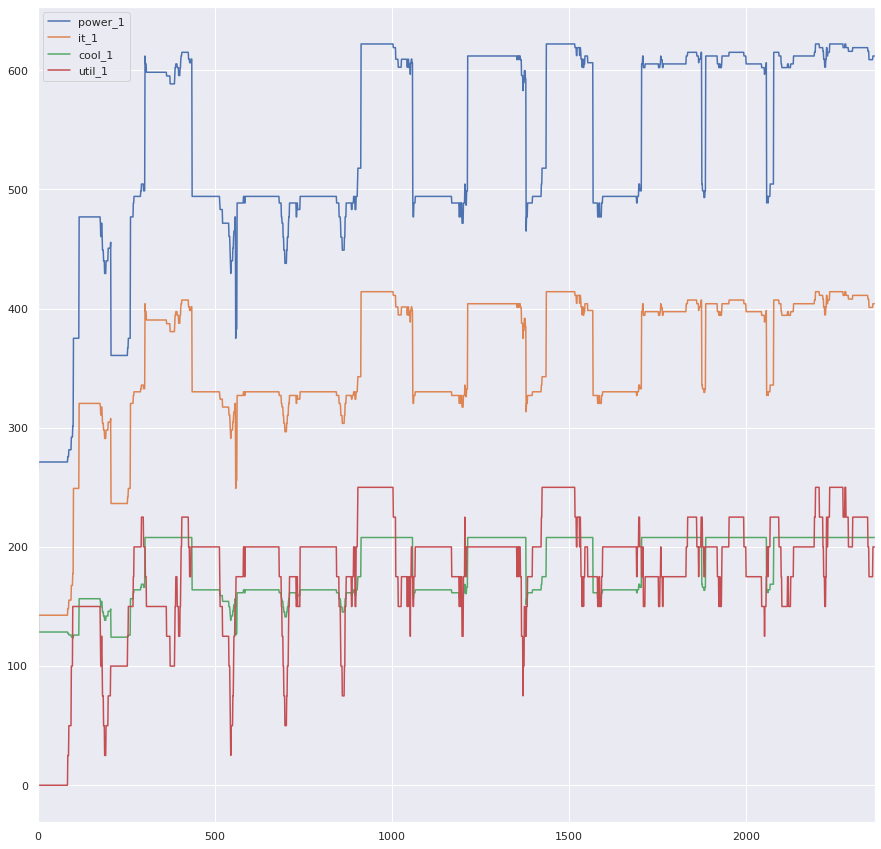

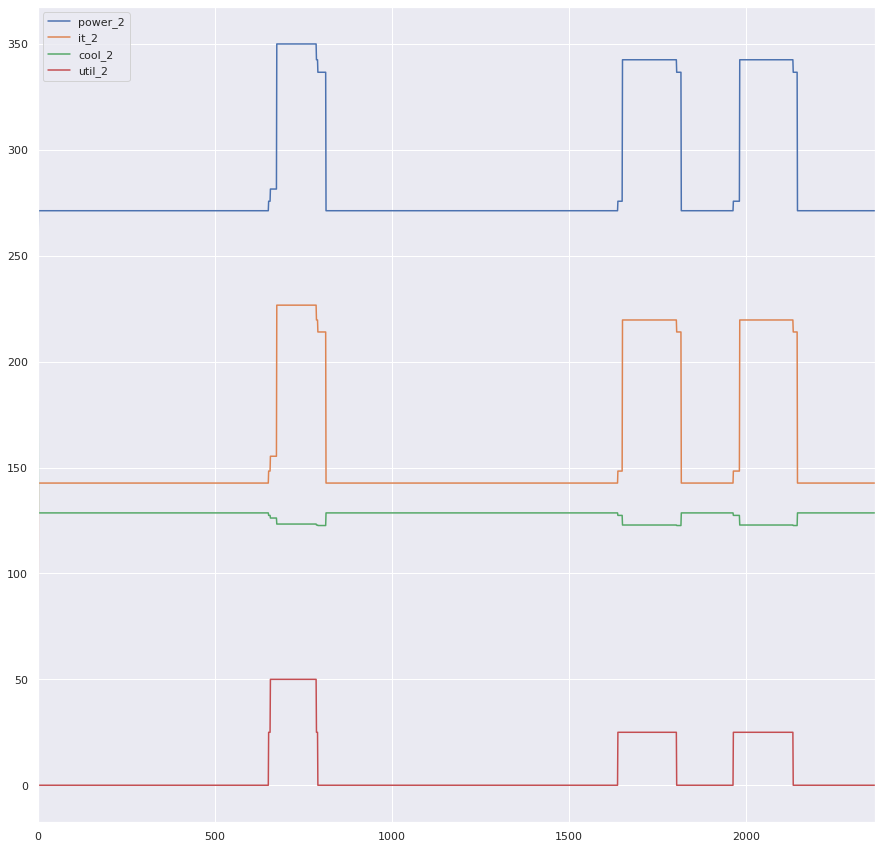

In [78]:
for i in range(3):
    scaled_df.plot(y=["power_"+str(i),"it_"+str(i),"cool_"+str(i),"util_"+str(i)], figsize=(15,15))

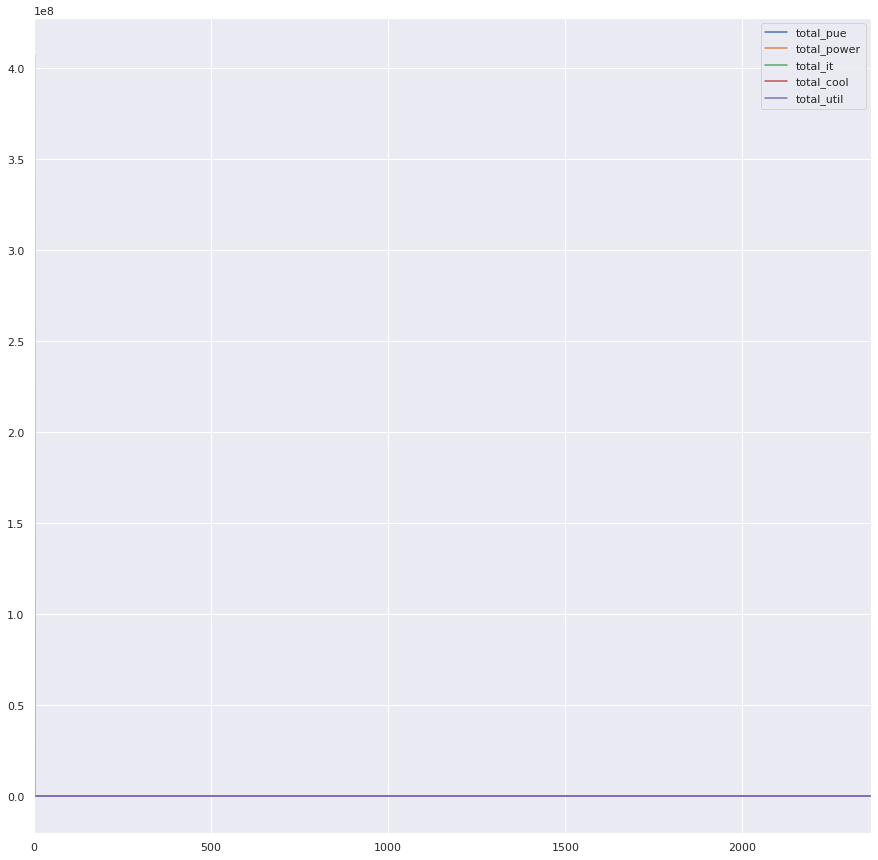

In [79]:
scaled_df["total_power"] = scaled_df["power_0"] + scaled_df["power_1"] + scaled_df["power_2"]
scaled_df["total_it"] = scaled_df["it_0"] + scaled_df["it_1"] + scaled_df["it_2"]
scaled_df["total_cool"] = scaled_df["cool_0"] + scaled_df["cool_1"] + scaled_df["cool_2"]
scaled_df["total_util"] = scaled_df["util_0"] + scaled_df["util_1"] + scaled_df["util_2"]
scaled_df.plot(y=[col for col in scaled_df.columns if "total" in col], figsize=(15,15))
plt.show()

In [80]:
scaled_df.describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_pue,total_power,total_it,total_cool,total_util
count,2.364000e+03,2364.000000,2.364000e+03,2364.000000,2.364000e+03,2364.000000,2.364000e+03,2364.000000,2.364000e+03,2364.000000,2.364000e+03,2364.000000,2.364000e+03,2.364000e+03,2.364000e+03,2.364000e+03,2364.000000,2364.000000,2364.000000,2364.000000
mean,9.018718e+02,1125.832089,9.180051e+02,207.827021,1.808164e+02,537.913092,3.552698e+02,182.643251,6.387479e+00,285.734069,1.581985e+02,127.535613,3.446228e+05,3.446231e+05,3.446234e+05,3.446231e+05,1949.479250,1431.473367,518.005885,1089.075720
std,1.195498e+02,46.256878,4.513835e+01,3.149300,5.317879e+01,88.488342,6.286272e+01,27.554188,1.370058e+01,28.893515,3.144016e+01,4.211818,1.184566e+07,1.184566e+07,1.184566e+07,1.184566e+07,117.066433,98.509701,28.544440,140.220800
min,3.516609e-07,250.000000,6.137338e-07,124.422455,3.516609e-07,250.000000,6.137338e-07,123.485303,3.516609e-07,250.000000,6.137338e-07,122.624535,1.221762e+00,1.475715e+00,1.544045e+00,1.414026e+00,750.000001,0.000002,381.591893,0.000001
25%,8.750000e+02,1123.262840,9.153681e+02,207.894737,1.750000e+02,494.141101,3.301700e+02,163.971118,3.516609e-07,271.261171,1.426765e+02,128.584719,1.222495e+00,1.496626e+00,1.901233e+00,1.537146e+00,1899.048109,1400.567231,497.998542,1050.000000
50%,9.500000e+02,1136.097869,9.282031e+02,207.894737,2.000000e+02,595.226349,3.873316e+02,207.894737,3.516609e-07,271.261171,1.426765e+02,128.584719,1.223975e+00,1.502328e+00,1.901233e+00,1.542676e+00,1980.873659,1461.299371,538.414010,1125.000000
75%,9.750000e+02,1142.274215,9.343795e+02,207.894737,2.000000e+02,611.974830,4.040801e+02,207.894737,3.516609e-07,271.261171,1.426765e+02,128.584719,1.227116e+00,1.518008e+00,1.901233e+00,1.546566e+00,2023.336587,1481.478967,544.374193,1175.000000
max,1.000000e+03,1145.362388,9.374677e+02,250.000000,2.500000e+02,622.064628,4.141699e+02,250.000000,5.000000e+01,349.998549,2.266764e+02,250.000000,4.073427e+08,4.073427e+08,4.073427e+08,4.073427e+08,2099.877444,1561.222482,750.000001,1250.000000


# Baseline Comparison

In [81]:
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",]
df_2 = pd.read_csv('../data/closest_trajectory.csv',
                 delimiter=";",
                 names=COLUMN_NAMES)
for i in range(3):
    df_2["pue_"+str(i)] = df_2["power_"+str(i)] / df_2["it_"+str(i)]

for col in ["power", "it", "cool", "util"]:
    df_2["total_"+col] = df_2[col+"_0"] + df_2[col+"_1"] + df_2[col+"_2"]
    
df_2["total_pue"] = (df_2["pue_0"] + df_2["pue_1"] + df_2["pue_2"])/3


df_2 = df_2[~df_2.isin([np.nan, np.inf, -np.inf]).any(1)]

df_2.describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.00000,2281.000000
mean,391.286716,818.327412,610.539774,207.787638,425.010960,851.675989,643.888351,207.787638,149.276633,457.110447,305.575569,151.534877,1.343904,1.326100,1.497738,2127.113848,1560.003694,567.110153,965.57431,1.389247
std,100.829778,59.078127,58.171404,2.952505,120.371546,60.729502,59.788069,2.952505,58.104400,59.607820,40.973313,19.338210,0.038558,0.037588,0.032364,140.303127,126.049252,20.484035,239.26500,0.029507
min,0.000000,271.261171,142.676453,124.422455,0.000000,271.261171,142.676453,124.422455,0.000000,271.261171,142.676453,122.863153,1.298953,1.294820,1.475715,813.783512,428.029358,373.267365,0.00000,1.361346
25%,325.000000,785.808052,577.913315,207.894737,325.000000,820.561142,612.666405,207.894737,125.000000,429.452301,291.012962,138.439338,1.315159,1.301632,1.486250,2059.561410,1494.796333,554.228812,775.00000,1.376654
50%,400.000000,816.216842,608.322105,207.894737,450.000000,870.633239,662.738503,207.894737,175.000000,471.639223,317.334953,154.304270,1.341751,1.313690,1.493819,2156.733676,1588.877899,570.093743,1025.00000,1.381047
75%,475.000000,867.545066,659.650330,207.894737,525.000000,897.128578,689.233841,207.894737,200.000000,494.141101,330.169983,163.971118,1.359733,1.339328,1.496626,2216.751040,1640.560959,579.760592,1175.00000,1.395392
max,550.000000,903.304924,695.410187,207.894737,600.000000,913.051780,705.157043,207.894737,225.000000,615.063003,407.168266,207.894737,1.901233,1.901233,1.901233,2334.584769,1710.900558,623.684211,1250.00000,1.901233


In [82]:
df_results = pd.DataFrame()

df_results["e-power"] = scaled_df.describe()["total_power"]
df_results["c-power"] = df_2.describe()["total_power"]
df_results["saving-power"] = (1 - df_results["e-power"]/df_results["c-power"])*100

df_results["e-pue"] = scaled_df.describe()["total_pue"]
df_results["c-pue"] = df_2.describe()["total_pue"]
df_results["saving-pue"] = (1 - df_results["e-pue"]/df_results["c-pue"])*100

df_results

,e-power,c-power,saving-power,e-pue,c-pue,saving-pue
count,2364.000000,2281.000000,-3.638755,2.364000e+03,2281.000000,-3.638755e+00
mean,1949.479250,2127.113848,8.350968,3.446231e+05,1.389247,-2.480636e+07
std,117.066433,140.303127,16.561779,1.184566e+07,0.029507,-4.014472e+10
min,750.000001,813.783512,7.837897,1.414026e+00,1.361346,-3.869694e+00
25%,1899.048109,2059.561410,7.793567,1.537146e+00,1.376654,-1.165818e+01
50%,1980.873659,2156.733676,8.153998,1.542676e+00,1.381047,-1.170338e+01
75%,2023.336587,2216.751040,8.725132,1.546566e+00,1.395392,-1.083379e+01
max,2099.877444,2334.584769,10.053493,4.073427e+08,1.901233,-2.142519e+10


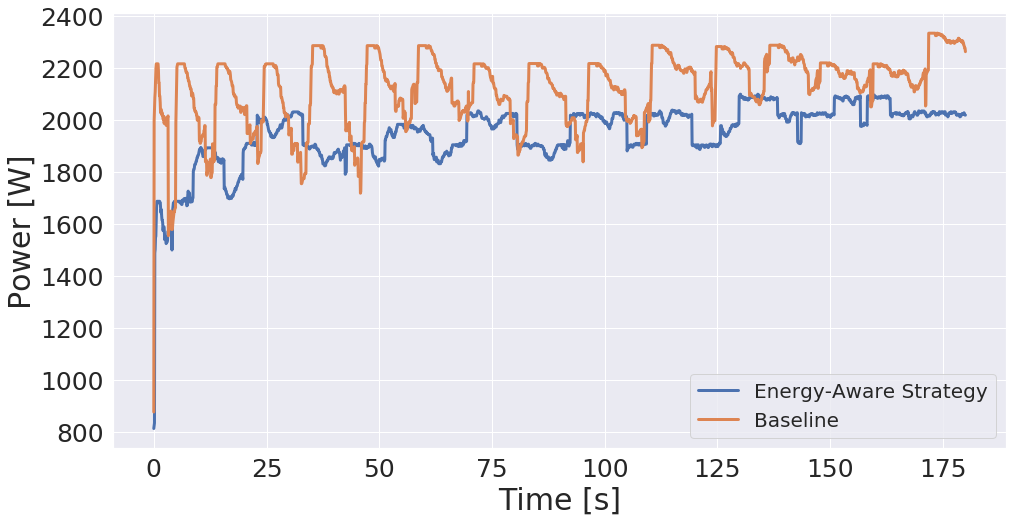

In [83]:
sim_time = 180
off=2
time_scaled = np.linspace(0, sim_time, len(scaled_df)-off)
time_2 = np.linspace(0, sim_time, len(df_2)-off)


plt.figure(figsize=(16,8))
plt.plot(time_scaled, scaled_df["total_power"][off:], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_power"][off:], label="Baseline", linewidth=3)
plt.ylabel("Power [W]", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.show()

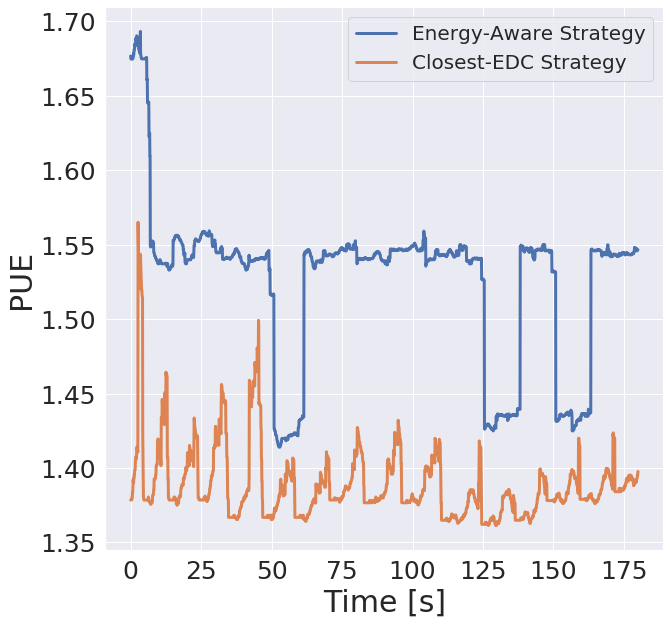

In [84]:
sim_time = 180
off=10
time_scaled = np.linspace(0, sim_time, len(scaled_df)-off)
time_2 = np.linspace(0, sim_time, len(df_2)-off)


plt.figure(figsize=(10,10))
plt.plot(time_scaled, scaled_df["total_pue"][off:], label="Energy-Aware Strategy", linewidth=3)
plt.plot(time_2, df_2["total_pue"][off:], label="Closest-EDC Strategy", linewidth=3)
plt.ylabel("PUE", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.show()

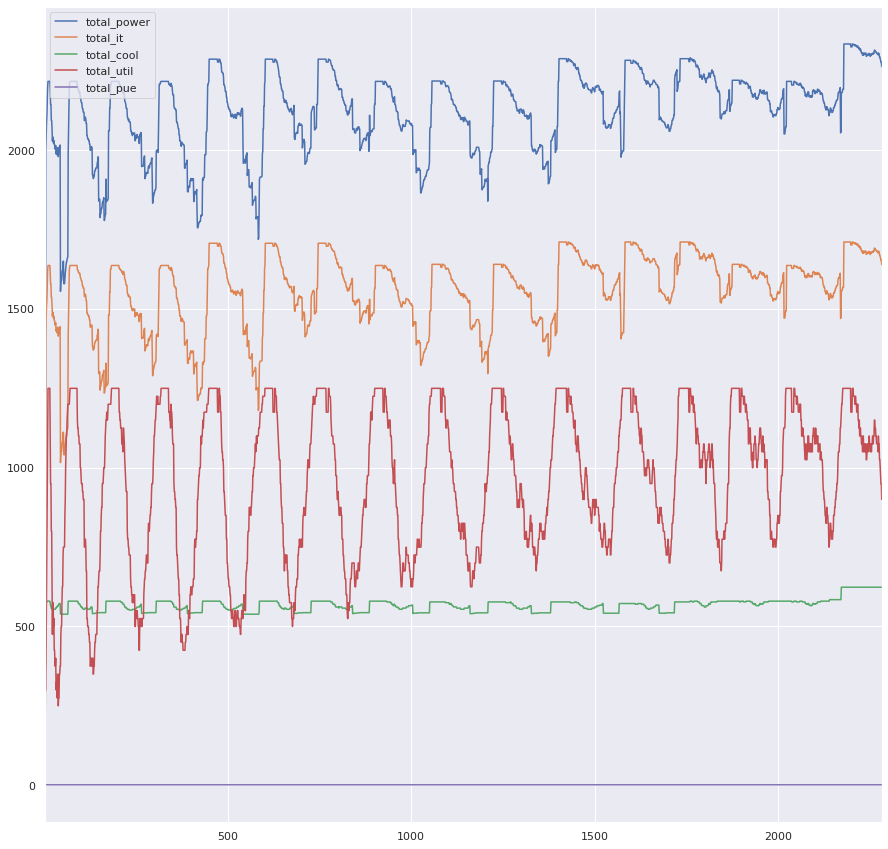

In [85]:
df_2.plot(y=[col for col in df_2.columns if "total" in col], figsize=(15,15))
plt.show()

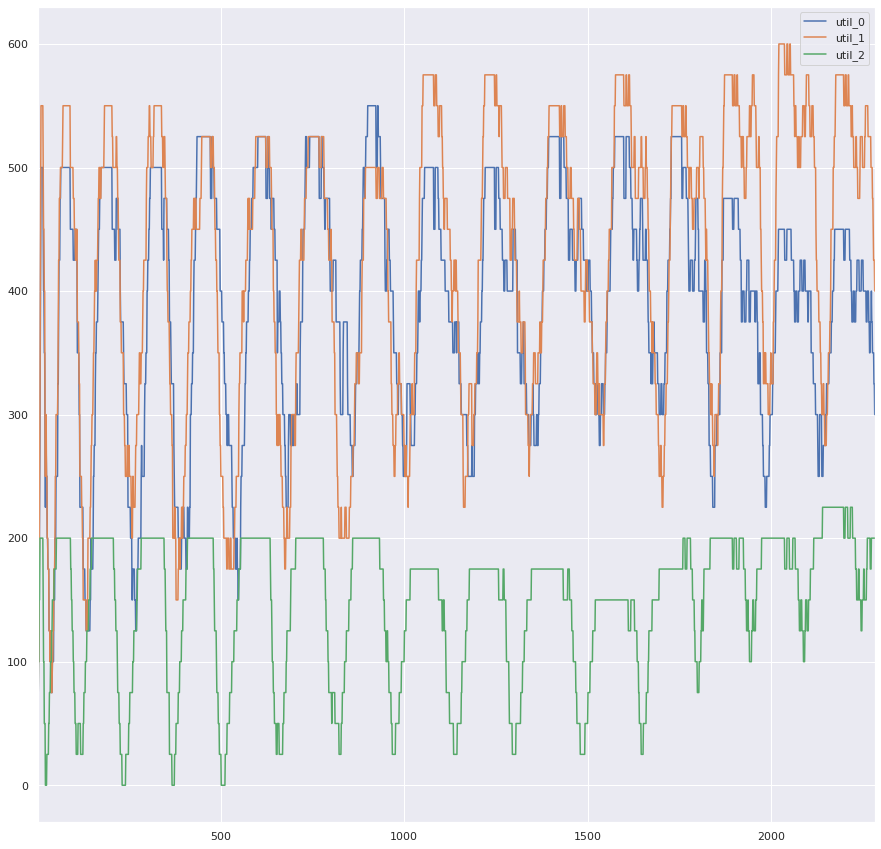

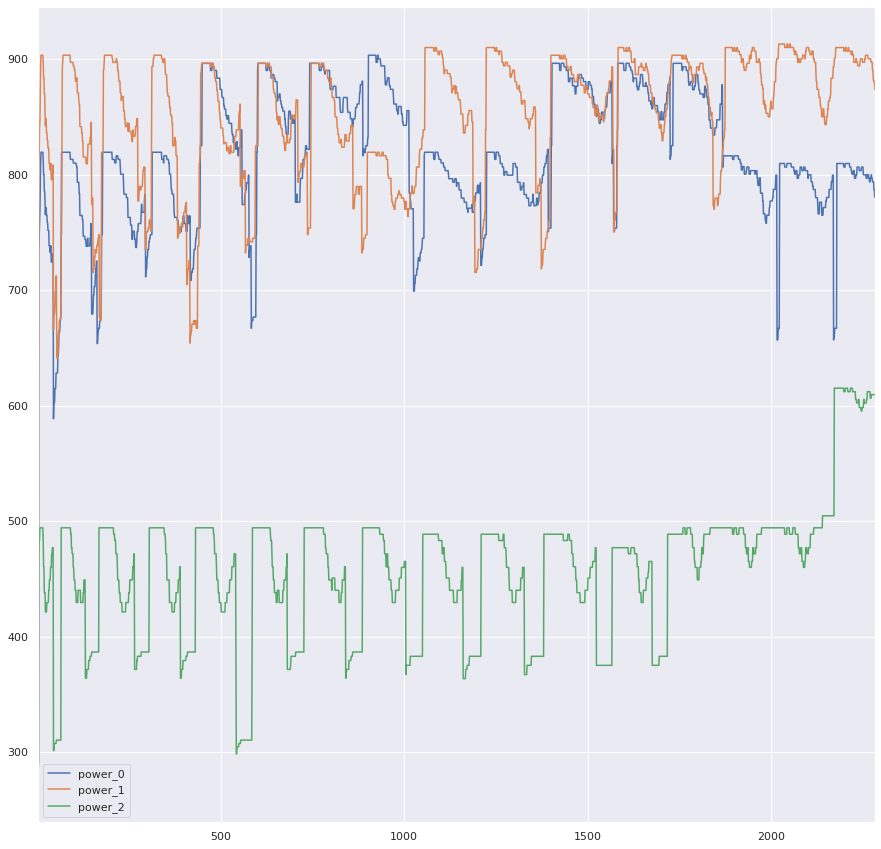

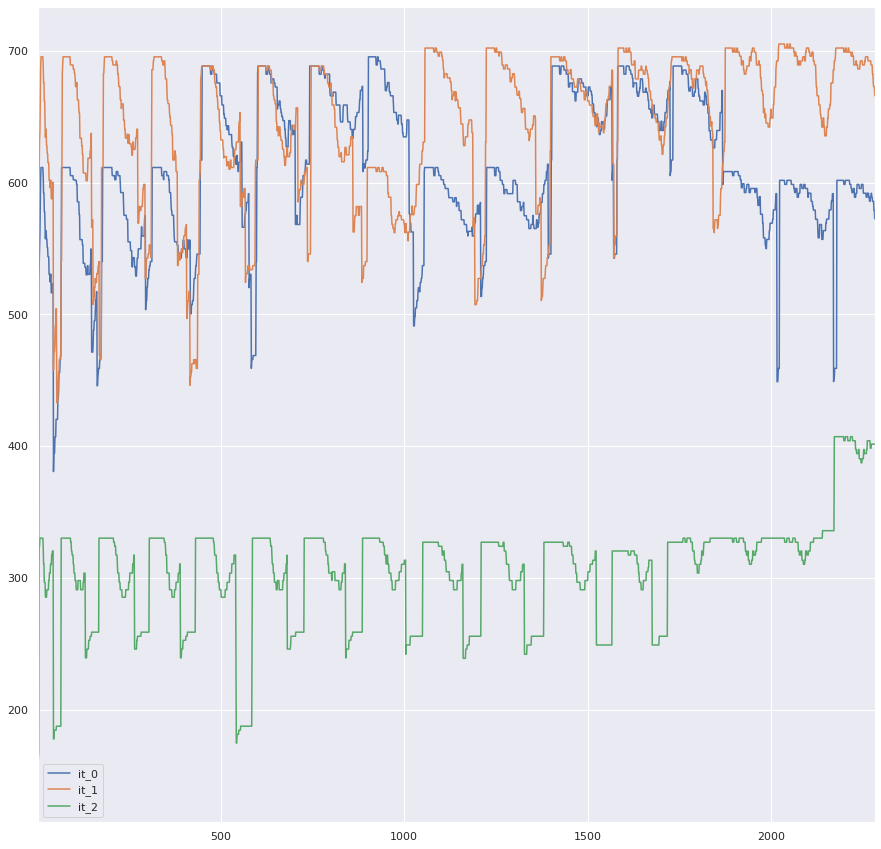

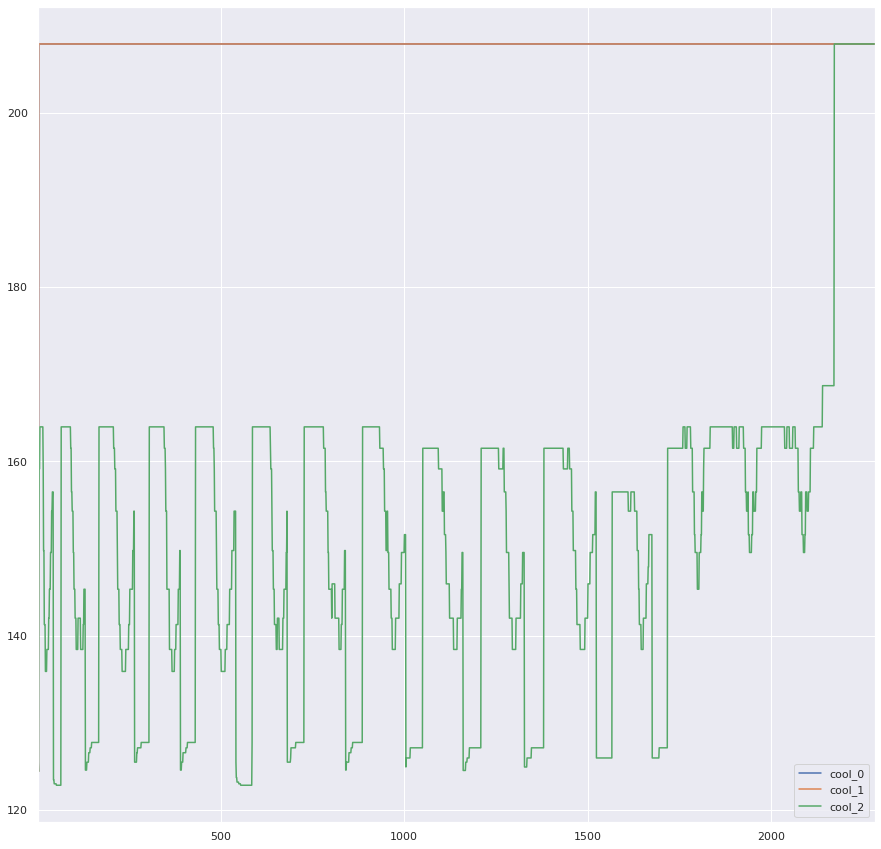

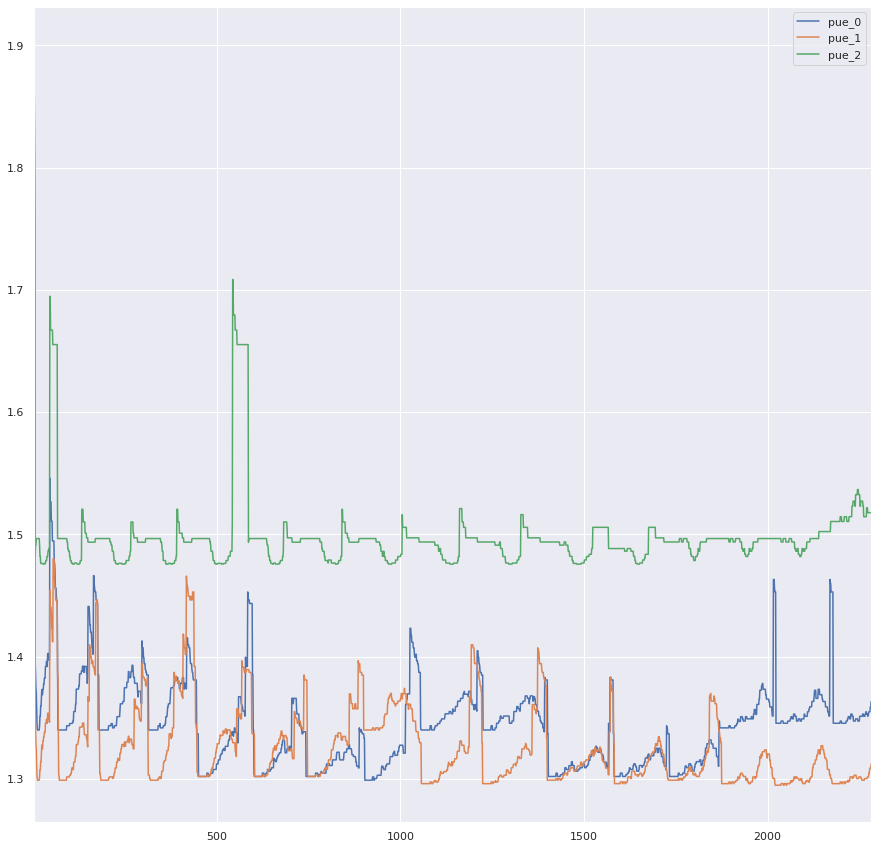

In [86]:
for col in ["util", "power", "it", "cool","pue"]:
    df_2.plot(y=[col+"_0", col+"_1", col+"_2"], figsize=(15,15))

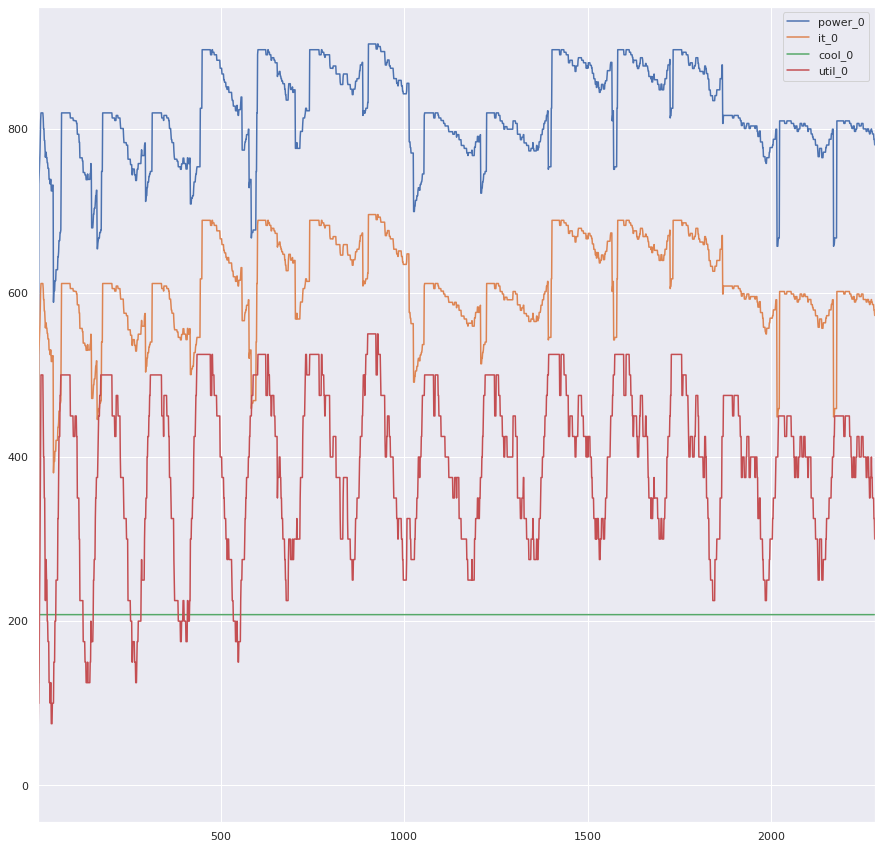

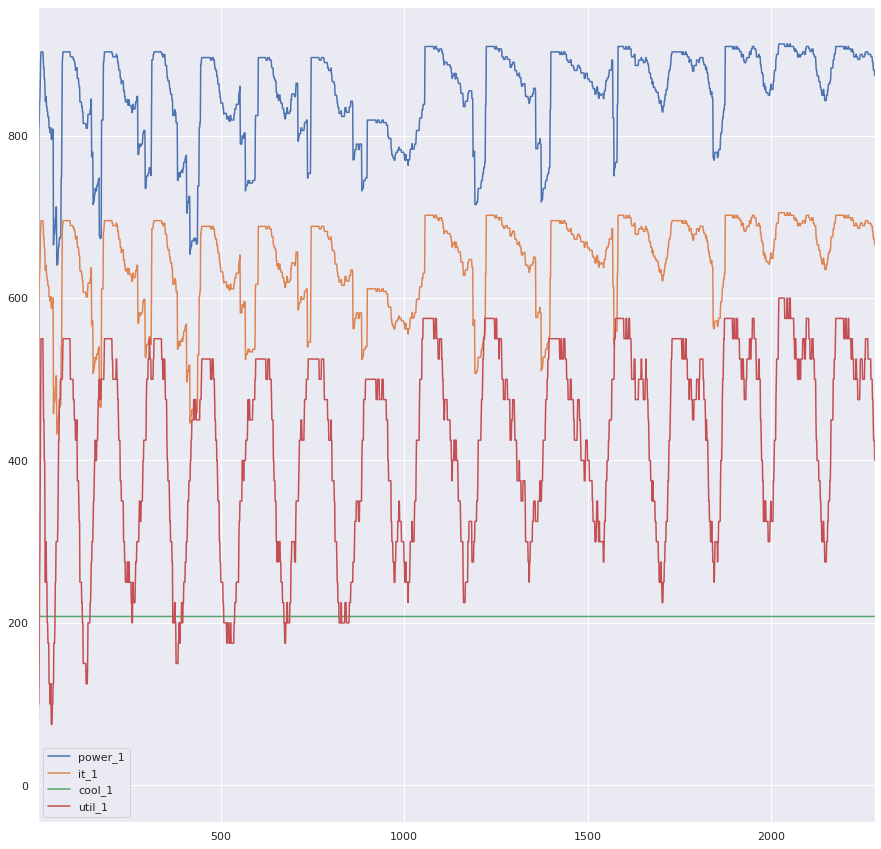

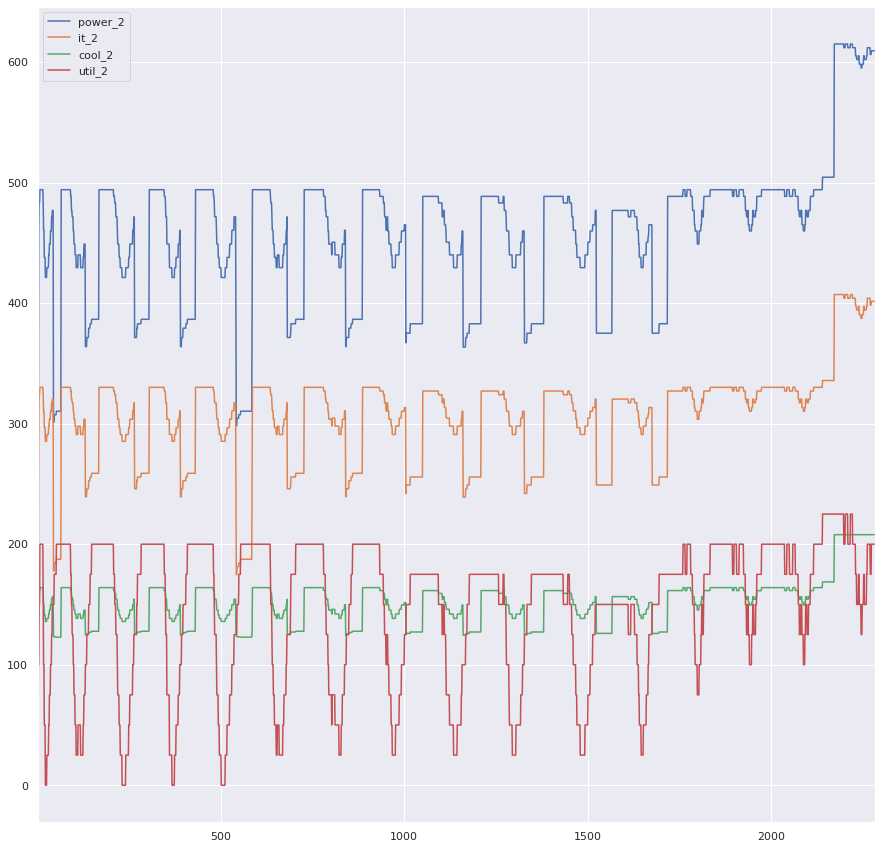

In [87]:
for i in range(3):
    df_2.plot(y=["power_"+str(i),"it_"+str(i),"cool_"+str(i),"util_"+str(i)], figsize=(15,15))

# Episodes: Loss, Mean Reward, etc.

In [38]:
! ls ../info

dist.txt	     vanilla_a3c_training_info.txt
mercury_info_parsed  vanilla_a3c_training_results.csv
train_arrays.txt


In [39]:
df_4 = pd.read_csv('../info/vanilla_a3c_training_results.csv',
                   delimiter=";",
                   names=["episodes", "length", "rewards", "loss", "entropies"])
df_4

,episodes,length,rewards,loss,entropies
0,0,6982,-1.583916e+07,-0.096793,-1.081331e-03
1,1,7232,-1.632648e+07,-0.084563,-1.061529e-03
2,2,7058,-1.582965e+07,-0.105851,-1.066351e-03
3,3,7150,-1.616263e+07,-0.089563,-1.054567e-03
4,4,7079,-1.593669e+07,-0.066547,-1.032938e-03
5,5,7309,-1.649758e+07,-0.045831,-1.002964e-03
6,6,7283,-1.636355e+07,-0.019175,-9.808643e-04
7,7,7220,-1.624072e+07,-0.030836,-9.668272e-04
8,8,7261,-1.639382e+07,-0.001281,-9.492381e-04
9,9,7338,-1.661641e+07,0.014171,-9.192682e-04


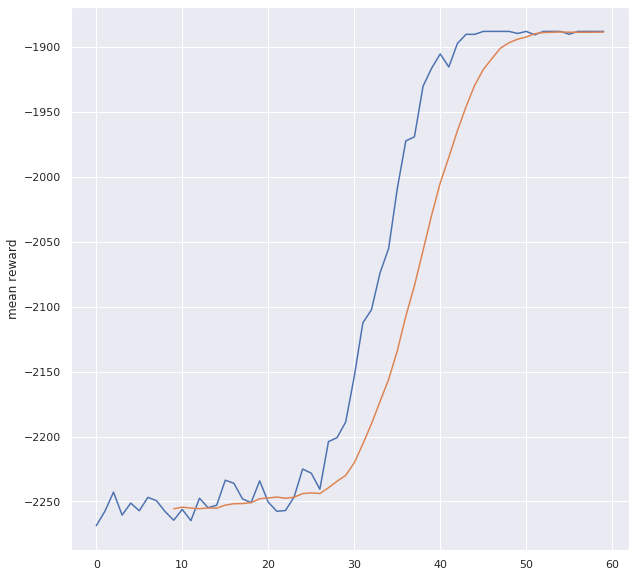

In [40]:
plt.figure(figsize=(10,10))
plt.plot(df_4["rewards"]/df_4["length"])
plt.plot(pd.Series.rolling(pd.Series(df_4["rewards"]/df_4["length"]), 10).mean())
plt.ylabel("mean reward")
plt.show()

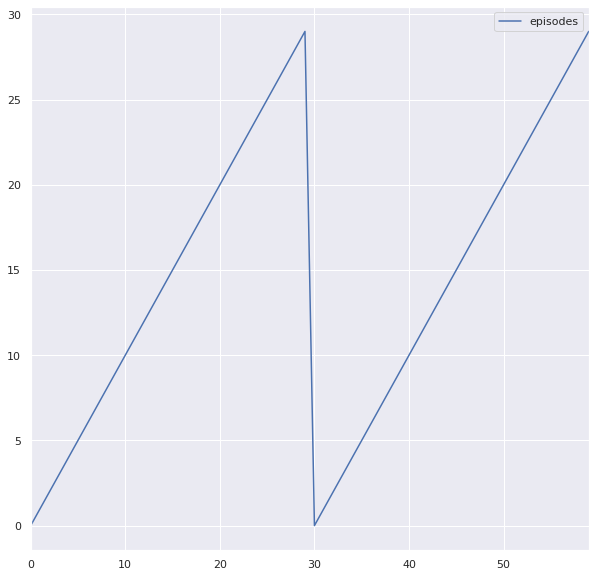

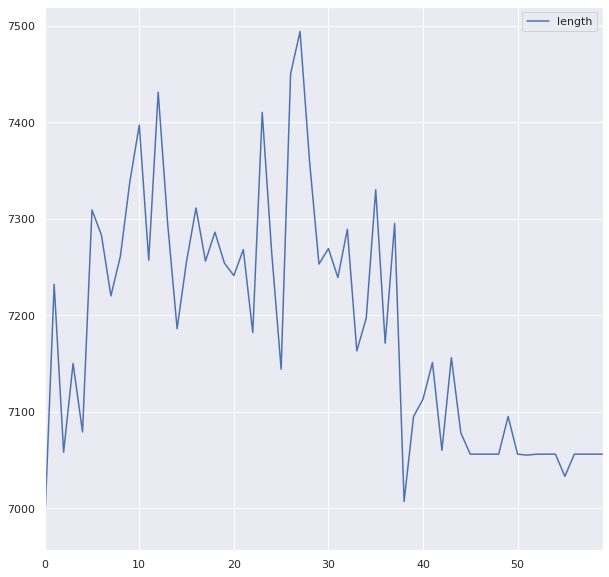

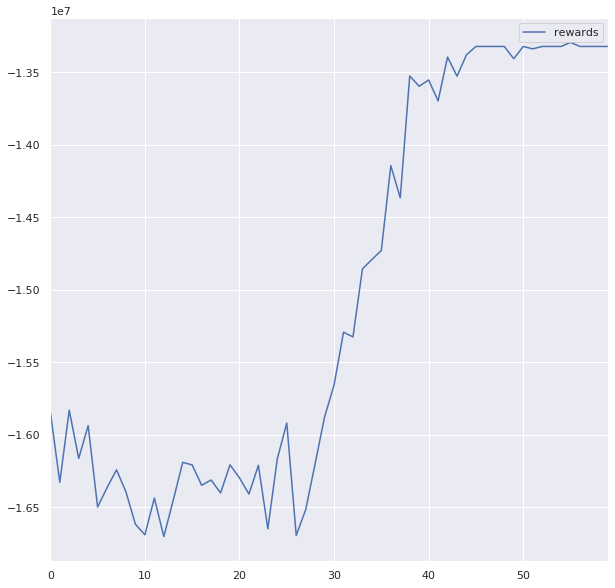

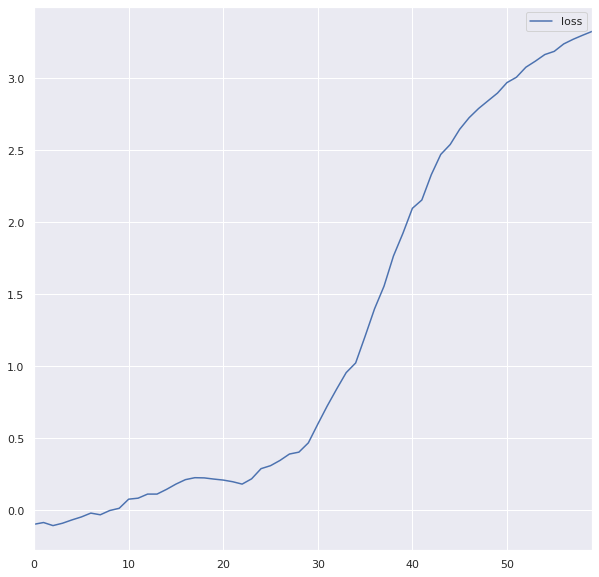

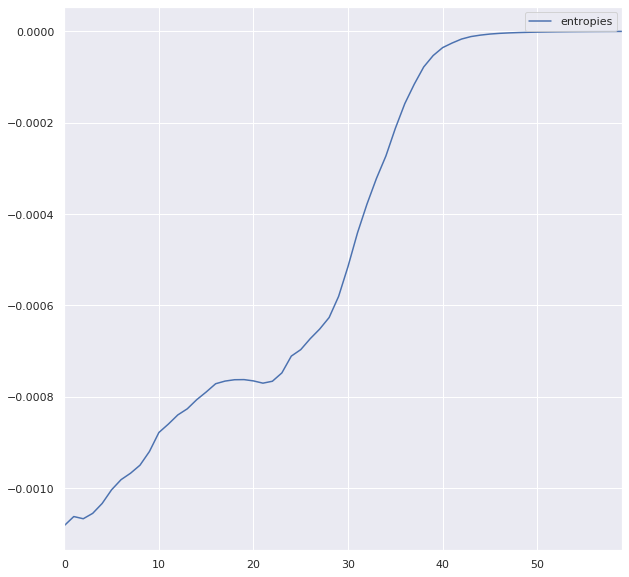

In [41]:
for col in df_4.columns:
    df_4.plot(y=col, figsize=(10,10))

In [92]:
!cat ../info/vanilla_a3c_training_info.txt

Saving intial model's weights!
Saving new best model's weights!
episode: 0, time: 90.58313250541687, length: 7100, mean reward: -2268.4243728680676, loss: -0.2291630208492279 0.5162419676780701 -0.001044989563524723
Saving new best model's weights!
episode: 1, time: 87.81165885925293, length: 7253, mean reward: -2244.3671688688355, loss: -0.2638932466506958 0.5342105031013489 -0.0010340568842366338
episode: 2, time: 88.63560366630554, length: 7103, mean reward: -2267.47828054126, loss: -0.2743164002895355 0.518650472164154 -0.0010296535911038518
episode: 3, time: 88.5739049911499, length: 6984, mean reward: -2259.5544430622394, loss: -0.2714783251285553 0.5455468893051147 -0.0010388842783868313
episode: 4, time: 87.70579600334167, length: 7012, mean reward: -2271.935302960689, loss: -0.2826628088951111 0.5501481890678406 -0.001030357787385583
episode: 5, time: 87.86701226234436, length: 7006, mean reward: -2257.3199717276375, loss: -0.2905755341053009 0.5411126613616943 -0.001015865476

# Episodes (2nd Option)

### Training info file must be cleaned before!! (remove lines with no commas)

In [19]:
df_5 = pd.read_csv('../info/vanilla_a3c_training_info.txt',
                   delimiter=",",
                   names=["episodes", "time", "length", "mean rewards", "loss"])

def compute_loss(x):
    losses = x.split(":")[1].split(" ")
    return sum([float(l) for l in losses[1:]])

for col in df_5.columns[:-1]:
    df_5[col] = df_5[col].str.split(":").str[1].astype(np.float)
df_5["entropy"] =  df_5["loss"].str.split(":").str[1].str.split(" ").str[3].astype(np.float)
df_5["loss"] =  df_5["loss"].apply(compute_loss)
df_5

AttributeError: 'float' object has no attribute 'split'

In [ ]:
for col in df_5.columns:
    df_5.plot(y=col, figsize=(10,10))